# Download Files

In [ ]:
!curl 'https://twsytg.db.files.1drv.com/y4m_huv7tjlXyVw5k_GMkWix7DuLsDf2Xx4TQXeh5aUVlZJLTYtTzkVOAjyG_EUudssl2qyCG8GBOIl3u912PEb2hMGlwt9OW6koxH1guHNcflnJi0NcP1QpLmofCYv7N9H9yJEwuZwfIUb_1frySN-OEnjdw2EpVvNrlghe2cS1CdxBJpNJnAy8vZ5dMLFttYw2z5MIljv_AXgenrsP3ak9w' -H 'User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:89.0) Gecko/20100101 Firefox/89.0' -H 'Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8' -H 'Accept-Language: en-US,en;q=0.5' --compressed -H 'Referer: https://onedrive.live.com/' -H 'Connection: keep-alive' -H 'Upgrade-Insecure-Requests: 1' -H 'TE: Trailers' --output MVG.zip
!unzip MVG.zip
!mv MVG\ Assignment/* ./
!ls

# Assignment on Pose reconstruction
---
### Task description:
You will be given a g2o file which contains odometry information. The structure of a g2o consists of lines where each line is either an EDGE_SE2 or VERTEX_SE2. VERTEX_SE2 represent pose locations, however EDGE_SE2 represent transformation between two poses. You can read more on lie algebra, however this is not required for most of your tasks or for understanding transformations. 
The task is to reconstruct the pose locations given odometry information. More information on datatypes will be presented with the associated code.

Estimated time required ~3-5 hours

In [1]:
import fileinput
import numpy as np 
import matplotlib.pyplot as plt  
#from gtsam import Pose2 as gtpose2

Below are some helper functions for plotting as well as reading the files. You can go through the plotting function for seeing how direction is plotted. It is important to note that you will RARELY use matplotlib to plot.

The function to read file has some useful information on how g2o files are stored. It would be advisable for you to go through the code as well as comments.

In [2]:
%matplotlib inline 
def draw_traj(poses):
    # Plot Ground truth
    plt.plot(poses[:, 0], poses[:, 1], 'c-', label='Ground Truth')
    for i in range(0, len(poses[:, 2]), 5):
        x2 = 0.25*np.cos(poses[i, 2]) + poses[i, 0]
        y2 = 0.25*np.sin(poses[i, 2]) + poses[i, 1]
        plt.plot([poses[i, 0], x2], [poses[i, 1], y2], 'c>')

    plt.show()
    plt.close()
    
def read_file(filename):
    #This function returns odometry edges. 
    #For the purpose of this assignment, information matrix 
    #information is ignored
    
    # VERTEX_SE2: Pose locations
    # EDGE_SE2: Transformation between poses information
    odometry_edges = []
    for line in fileinput.input(files=filename):
        line_parts = line.split()
        if line_parts[0] == 'EDGE_SE2':
            #This is how the g2o file edge information is structured
            edge_from = int(line_parts[1])
            edge_to = int(line_parts[2])
            dx = float(line_parts[3])
            dy = float(line_parts[4])
            dtheta = float(line_parts[5])
            #Odometry edges have a difference of one 
            if abs(edge_from - edge_to) == 1:
                odometry_edges.append([dx, dy, dtheta])

        if line_parts[0] == 'VERTEX_SE2':
            #This part of the code is useless.
            #It is just for information on how 
            #VERTEX information is stored
            edge_no = int(line_parts[1])
            X = float(line_parts[2])
            Y = float(line_parts[3])
            THETA = float(line_parts[4])

    return odometry_edges

We will now write our pose class. You will have to fill in these functions to understand how SE2 elements work. Each SE2 element is represented by 3 values: (x,y, theta). These transformations are only for the 2-D plane. To convert these three values into the transformation matrix form you are comfortable with, there are two steps. Convert theta into the rotation matrix for a 2D plane as covered in class. Apply (x,y) as a translation vector and you will have a 3x3 matrix that looks something like this:
\begin{matrix}
Rc & -Rs & x\\
Rs & Rc & y\\
0 & 0 & 1
\end{matrix}

For our robot, every odometry edge is described in the LOCAL FRAME OF THE ROBOT. Keep this in mind when you consider pre or post multiplication of transforms

In [3]:
class Pose2(object):
    """
    docstring for Pose2:
    Inspired by gtsams funcationality,
    this is a small toy class with basic
    functionality for SE2 data
    For the purposes of this assignment, 
    these are enough
    """
    def __init__(self, *args):
        """
        constructor for initialising with points
        We want to initialize self.x, self.y, self.theta and self.mat
        """
        if len(args) == 3:
            """
            if Pose2 is initialised with 3 values, 
            ex: temp = Pose2(0.3,0.4, 0.2)
            then we want to invoke this condition.
            Fill in the remaining code 
            """
            x = args[0]
            y = args[1]
            theta = args[2]
            #Fill the remaining here
            self.x = x
            self.y = y
            self.theta = theta
            self.mat = np.array([[np.cos(theta), -np.sin(theta), x], [np.sin(theta), np.cos(theta),y], [0,0,1]])

        else:
            """
            if Pose2 is initialised with a transfrom matrix, 
            ex: temp = Pose2(rot_mat)
            then we want to invoke this condition.
            Fill in the remaining code 
            """
            matrix = args[0]
            self.mat = matrix
            self.x = matrix[0,2]
            self.y = matrix[1,2]
            self.theta = np.arccos(matrix[0,0])
            

    def matrix(self):
        """
        returns SE2 in matrix form
        """
        return self.mat
    def pose(self):
        """
        returns SE2 in pose form
        """
        return np.array([self.x,self.y,self.theta])

### Main Task

Odometry edges are loaded in an array that is passed as an argument to the reconstruct function. Each odometry edge is a transformation between point a -> b, where a and b are consecutive points. The odometry edges are placed in order in the array and the **ith edge is a transformation between the ith and i+1th pose**. You have to create the transformation matrix. Initialise a pose variable with the transformation matrix and you can return pose points using the required function. Each entry in the points array is an array of [x,y,theta]

In [4]:
def reconstruct_points(starting_frame, odometry_edges):
    points = [starting_frame]
    current_frame_SE2 = Pose2(starting_frame[0], starting_frame[1], starting_frame[2])
    # current_frame_SE2 = gtpose2(starting_frame[0], starting_frame[1], starting_frame[2])
    for edge in odometry_edges:
        """
        Your task is to fill points with the respective poses as per odometry edges.
        This and the Pose2 class code snippets are the only code snippets you have to edit
        points is a 2D array where each entry is an array of 3 points of the form
        [x,y, theta]
        """
        transform_mat_SE2 = Pose2(edge[0], edge[1], edge[2])
        tranform_mat = transform_mat_SE2.mat
        current_frame_mat = current_frame_SE2.mat
        next_frame = np.matmul(current_frame_mat, tranform_mat)
        current_frame_SE2 = Pose2(next_frame)

        next_points = current_frame_SE2.pose()
        points.append(next_points)
        

    return points 

## Driver Code

Below is the driver code. If you have coded everything correctly, this code should run without errors.

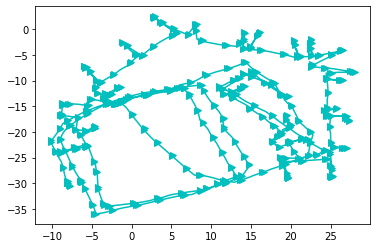

In [5]:
if __name__ == '__main__':
    """
    Driver code
    Task:
    Read odometry edges and reconstruct point positions
    """
    #Step 1: Read odometry edges
    filename = "intel_optimized.g2o"
    odometry_edges = read_file(filename)
    #Step 2: Decide starting point. It is given as follows:
    #starting_frame = np.array([0,0,0])
    starting_frame = np.array([-7.74569, -30.5557, 2.00585])
    #Step 3: Reconstruct all points. You are given odometry edges
    #which you have to use to reconstruct the points
    #Return the poses which you have to plot
    points = reconstruct_points(starting_frame, odometry_edges)
    #print(points)
    #Plot all poses
    draw_traj(np.array(points))

# Assignment on Direct Linear Transform and RANSAC

---
### Task description:
This assignment requires you to implement camera calibration technique.  You are expected to do the following:

- Perform the Direct Linear Transform on the given image (Note: You will have to manually find 3D - 2D point correspondence)
- Implement the RANSAC based variant of the above calibration method and report your observations.

Estimated time required ~4-6 hours

In [10]:
import matplotlib
matplotlib.use('TkAgg')
import numpy as np
import matplotlib.pyplot as plt

We'll be working with the image below. For DLT, remember that we need to have 3D world coordinates as well as 2D image coordinates. The grid like pattern will help us define our world points. For convenience, we'll use the following coordinate system:

red: x-axis
green: y-axis
blue: z-axis

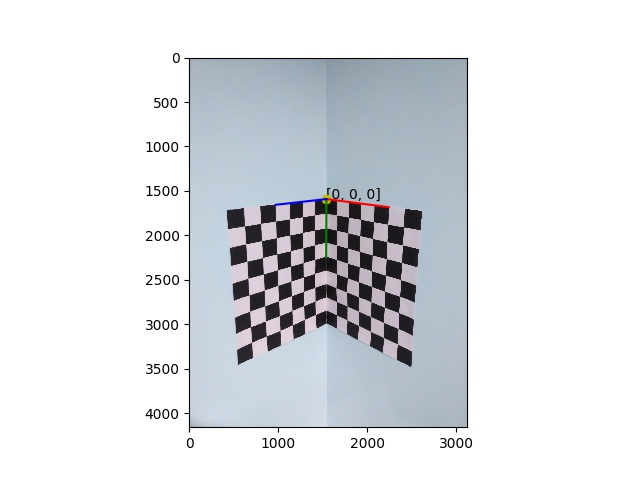

3D points: 
 [[0 0 0]
 [7 0 0]
 [7 9 0]
 [0 9 0]
 [0 9 7]
 [0 0 7]]
 
 Please click the corresponding points in the image following the order of given 3D points!

 corresponding image coordinates: 
 [[1587.68166034 1544.36659887]
 [1732.13685294 2617.46231532]
 [3486.23562021 2486.76476011]
 [2990.96067416 1544.36659887]
 [3438.08388934  546.93788807]
 [1711.50039685  423.11915156]]


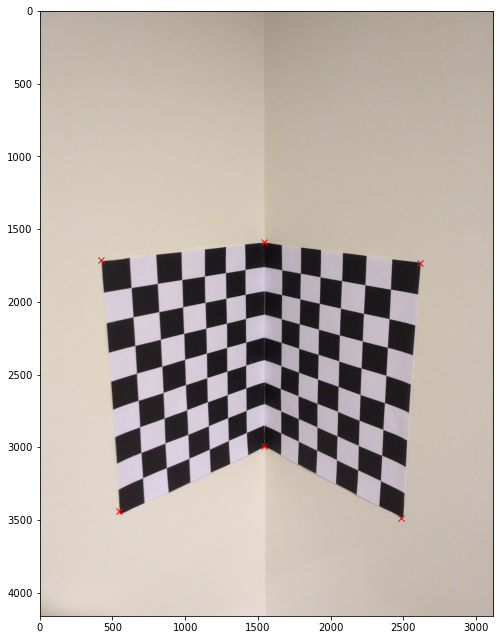

In [50]:
# load the input image
I = plt.imread("calib-object.jpg")
plt.imshow(I, cmap = 'gray')

# Defining the world coordinates
# Selecting the six corners as the main points
X = [[0, 0, 0],
     [7, 0, 0],
     [7, 9, 0],
     [0, 9, 0],
     [0, 9, 7],
     [0, 0, 7]]
X = np.array(X)
print("3D points: \n", X)

print(" \n Please click the corresponding points in the image following the order of given 3D points!")

# Get observed points from user
x = np.array(plt.ginput(len(X)))
print("\n corresponding image coordinates: \n", x)

plt.plot(x[:, 1], x[:, 0], 'rx')

In [51]:
# Now, for the system Mp=0, constructing the matrix M
M = np.zeros((12,12))
for i in range(12):
    M[i,0:3] = -1*X[int(i/2),0:3]
    M[i,3] = -1
    M[i,8:11] = x[i//2,i%2]*X[i//2,:]
    M[i,11] = x[i//2,i%2]

# Performing SVD for obtaining the solution for M    
U, S, V = np.linalg.svd(M)
#print(U.shape,S.shape,V.shape)

# Assigning the column vector associated with the smallest singular value
# as the most optimal solution for the matrix P
soln = V[:,10]
print(soln.shape)
        
# Constructing the matrix P from soln
Pm = np.zeros((3,4))
for i in range(12):
    Pm[i//4,i%3] = soln[i]
print(Pm)


(12,)
[[-8.00182042e-02 -5.42562238e-01 -8.10362900e-01  0.00000000e+00]
 [ 7.24337174e-05 -4.99589246e-05  3.31271309e-04  0.00000000e+00]
 [ 3.90401484e-20 -1.74853479e-20 -4.38960587e-21  0.00000000e+00]]


In [52]:
# Decomposition of the matrix P to K,R,X_o

# H = KR
# h = -KRX_o

H = Pm[0:3,0:3]
#print(H)
h = Pm[:,3]
#print(h)

X_0 = np.matmul(-np.linalg.inv(H),h)
print("The camera centre X_0: \n",X_0)

# Performing QR Decompostion for extracting K and R
q,r = np.linalg.qr(np.linalg.inv(H))

R = np.transpose(q)
print("The rotation frame R: \n",R)

K = np.linalg.inv(r)
print("The camera intrinsic matrix K: \n",K)

The camera centre X_0: 
 [0. 0. 0.]
The rotation frame R: 
 [[-0.41269721 -0.9096576  -0.04694739]
 [ 0.07376808 -0.08475056  0.99366776]
 [-0.90787625  0.40662069  0.10208001]]
The camera intrinsic matrix K: 
 [[ 5.64613577e-01 -7.65151825e-01 -2.30692261e-01]
 [ 0.00000000e+00  3.38750962e-04 -5.22590041e-05]
 [-0.00000000e+00 -0.00000000e+00 -4.30016188e-20]]


## General Steps

To help you get started, some steps that you'll have to do are:
1. Select points on the image and get their coordinates
2. Determine the corresponding world coordinates
3. Perform DLT
4. Repeat step 3 using RANSAC

If you're motivated, also decompose the projection matrix returned by DLT into R, K, and the Camera Center.